In [2]:
import os
from transformers import AutoTokenizer, TFAutoModelForTokenClassification, BertConfig
import tensorflow as tf
import numpy as np

# 경로 설정
train_dir = "C:/Users/doubl/Desktop/text/training"
val_dir = "C:/Users/doubl/Desktop/text/validation"
test_dir = "C:/Users/doubl/Desktop/text/test"

# 모델 설정
model_name = "monologg/kobert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = BertConfig.from_pretrained(model_name)

# 태스크 설정
num_labels = 2 # 0: 문장 시작, 1: 문장 내부
id2label = {0: 'S', 1: 'I'}
config.update({'id2label': id2label})



In [4]:
import os
from transformers import InputExample

# InputExample을 상속받는 CustomInputExample 클래스 생성
class CustomInputExample(InputExample):
    def __init__(self, words, labels, guid=None):
        self.guid = guid
        self.words = words
        self.labels = labels

def load_data(dir_path):
    examples = []
    for subdir, dirs, files in os.walk(dir_path):
        for file in files:
            if file.endswith('.txt'):
                with open(os.path.join(subdir, file), 'r', encoding='utf-8') as f:
                    text = f.read()

                tokens = list(text)
                token_labels = [1] * len(tokens)
                examples.append(CustomInputExample(guid=None, words=tokens, labels=token_labels))
    return examples

train_data = load_data(train_dir)
val_data = load_data(val_dir)



In [8]:
import numpy as np
def prepare_data(examples, tokenizer):
    input_ids, token_type_ids, attention_masks, labels = [], [], [], []

    for example in examples:
        encoded = tokenizer.encode_plus(
            example.words,
            is_split_into_words=True,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_attention_mask=True,
        )

        num_special_tokens_to_add = 2  # [CLS] and [SEP] tokens
        extra_padding_length = 128 - len(example.words) - num_special_tokens_to_add
        example_label = [-100] + example.labels[:127] + [-100] * extra_padding_length

        input_ids.append(encoded['input_ids'])
        token_type_ids.append(encoded['token_type_ids'])
        attention_masks.append(encoded['attention_mask'])
        labels.append(example_label)

    input_ids = np.stack(input_ids, axis=0).astype("int32")
    token_type_ids = np.stack(token_type_ids, axis=0).astype("int32")
    attention_masks = np.stack(attention_masks, axis=0).astype("int32")
    labels = np.stack(labels, axis=0).astype("int32")

    return input_ids, token_type_ids, attention_masks, labels

train_inputs = prepare_data(train_data, tokenizer)
val_inputs = prepare_data(val_data, tokenizer)



In [10]:
model = TFAutoModelForTokenClassification.from_pretrained(model_name, config=config, from_pt=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')


All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
print("Number of classes:", config.num_labels)


Number of classes: 2


In [17]:
sample_inputs = [train_inputs[0][:1], train_inputs[1][:1], train_inputs[2][:1]]
sample_output = model(sample_inputs)
print("Output logits shape:", sample_output.logits.shape)



Output logits shape: (1, 128, 2)


In [20]:
import numpy as np

def preprocess_labels(labels, seq_length, num_classes):
    processed_labels = np.zeros((len(labels), seq_length, num_classes), dtype=np.float32)
    for i, label_seq in enumerate(labels):
        for j, label in enumerate(label_seq):
            if 0 <= label < num_classes:
                processed_labels[i, j, label] = 1.0
            else:
                print(f"Warning: Ignoring invalid label value {label} at position ({i}, {j})")
    return processed_labels

train_labels = preprocess_labels(train_inputs[3], 128, config.num_labels)
val_labels = preprocess_labels(val_inputs[3], 128, config.num_labels)



In [27]:
import keras
model.compile(optimizer=optimizer,
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history = model.fit(
    x=[train_inputs[0], train_inputs[1], train_inputs[2]],
    y=train_labels,
    validation_data=([val_inputs[0], val_inputs[1], val_inputs[2]], val_labels),
    batch_size=16,
    epochs=5,
)



Epoch 1/5
37/37 [==============================] - ETA: 0s - loss: 0.0274 - categorical_accuracy: 0.9728WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000283202EA820> and will run it as-is.
Cause: generators are not supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: generators are not supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
37/37 [==============================] - 215s 6s/step - loss: 0.0274 - categorical_accuracy: 0.9728 - val_loss: 0.0054 - val_categorical_accuracy: 0.9922
Epoch 2/5
37/37 [==============================] - 196s 5s/step - loss: 0.0049 - categorical_accuracy: 0.9922 - val_loss: 0.0054 - val_categorical_accuracy: 0.9922
Epoch 3/5
37/37 [==============================] - 191s 5s/step - loss: 0.0043 - categorical_accuracy: 0.9922 - val_loss: 0.0041 - val_categorical_accuracy: 0.9922
E

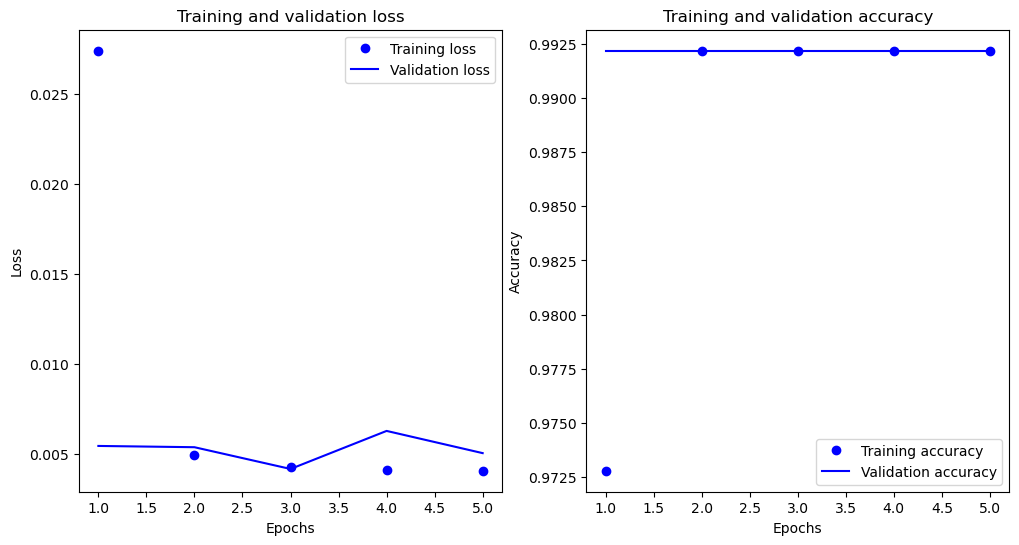

In [31]:
import matplotlib.pyplot as plt

# 시각화할 항목을 정의합니다.
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']

epochs = range(1, len(loss) + 1)

# 손실 값 플롯을 생성합니다.
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 플롯을 생성합니다.
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [30]:
test_data = load_data(test_dir)
test_inputs = prepare_data(test_data, tokenizer)

preds = model.predict([test_inputs[0], test_inputs[1], test_inputs[2]])
predicted_labels = np.argmax(preds.logits, axis=2)

for i, example in enumerate(test_data):
    token_labels = predicted_labels[i]
    for j, (token, label) in enumerate(zip(example.words, token_labels)):
        if label == 0:
            print()
        print(token, end="")



Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
가만히 보면 그 예전에 유행했던 다시금 이렇게 주목받는 모습들을 보게 되거든요 다시 통이 아주 넓은 바지가 유행이라고 합니다 오늘 좀 알아보죠 전해주세요 허벅지부터 쭉 일자로 통이 넓은 바지나 아니면 나팔바지 예전에 한 번쯤 입어한 번 사 주면 유행을 타지 않고 오래 있는 옷들이 있지요 대표적인 것이 체크무늬 옷인데요 다양한 체크무늬의 종류와 세련되게 입는 방법 알려 드립니다
 시대를 넘어 남녀노소 9분없이 누구에게나 사랑받는 체크무늬 가벼운 처리부터 정다시 송해 씨의 맥심 잡지 표지 모델 모습인데요 조금 다르지만 또 다른 스타들의 왜 모습 준비 하셨죠 스